## 1. Análisis Exploratorio
Descripción: Cargamos el CSV, definimos índice de fecha y visualizamos la serie de tiempo.

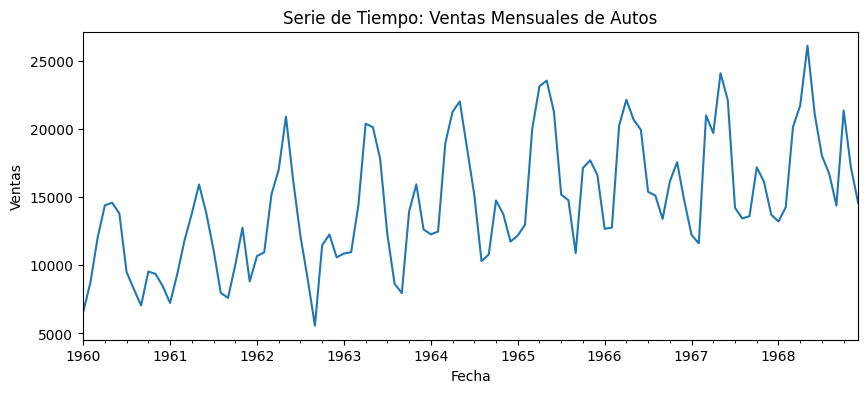

In [1]:
# 1. Análisis Exploratorio
import pandas as pd
import matplotlib.pyplot as plt

# Carga y formateo
df = pd.read_csv('data/monthly-car-sales.csv', parse_dates=['Month'])
df.set_index('Month', inplace=True)

# Visualización
plt.figure(figsize=(10,4))
df['Sales'].plot(title='Serie de Tiempo: Ventas Mensuales de Autos')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()


## 2. Promedios Móviles
Descripción: Calculamos MA(3) y MA(12) y los comparamos con la serie original.

<Figure size 1000x400 with 0 Axes>

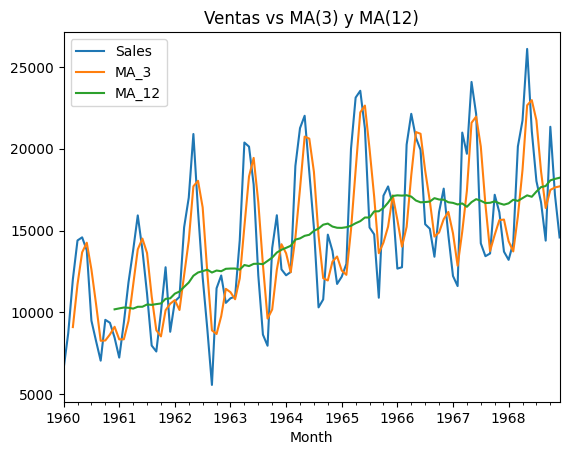

In [2]:
# 2. Promedios Móviles
df['MA_3'] = df['Sales'].rolling(window=3).mean()
df['MA_12'] = df['Sales'].rolling(window=12).mean()

plt.figure(figsize=(10,4))
df[['Sales','MA_3','MA_12']].plot()
plt.title('Ventas vs MA(3) y MA(12)')
plt.show()


## 3. Alisamiento
Descripción: Aplicamos Simple Exponential Smoothing (SES) y Holt para capturar nivel y tendencia.

c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Figure size 1000x400 with 0 Axes>

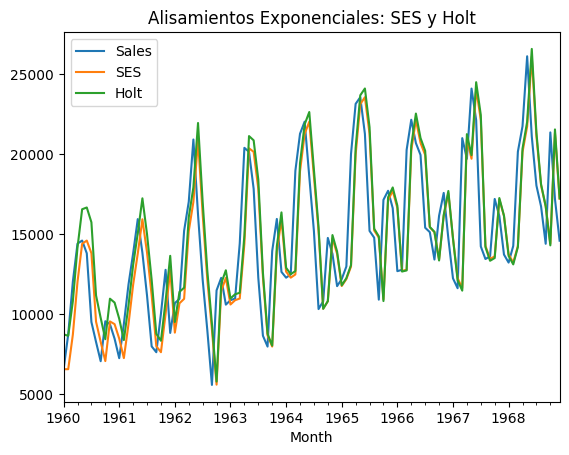

In [3]:
# 3. Alisamiento Exponencial
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

# SES
ses_model = SimpleExpSmoothing(df['Sales']).fit()
df['SES'] = ses_model.fittedvalues

# Holt
holt_model = Holt(df['Sales']).fit()
df['Holt'] = holt_model.fittedvalues

plt.figure(figsize=(10,4))
df[['Sales','SES','Holt']].plot()
plt.title('Alisamientos Exponenciales: SES y Holt')
plt.show()


## 4. Holt–Winters
Descripción: Ajustamos un modelo aditivo de Holt–Winters para capturar tendencia y estacionalidad (periodo 12).

c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Figure size 1000x400 with 0 Axes>

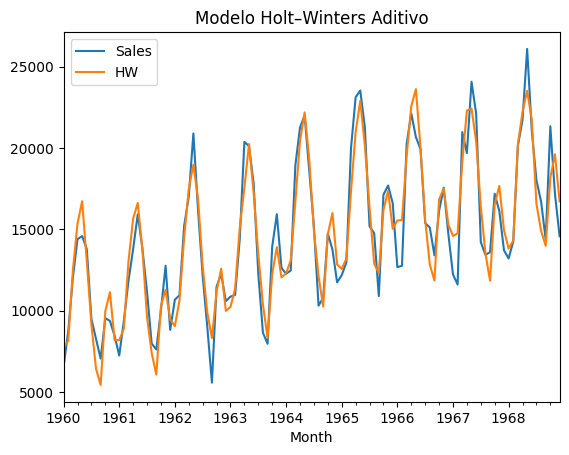

In [4]:
# 4. Holt–Winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(
    df['Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()
df['HW'] = hw_model.fittedvalues

plt.figure(figsize=(10,4))
df[['Sales','HW']].plot()
plt.title('Modelo Holt–Winters Aditivo')
plt.show()


## 5. SARIMA
Descripción: Ajustamos un SARIMA(1,1,1)(1,1,1,12) y mostramos el ajuste.

c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Figure size 1000x400 with 0 Axes>

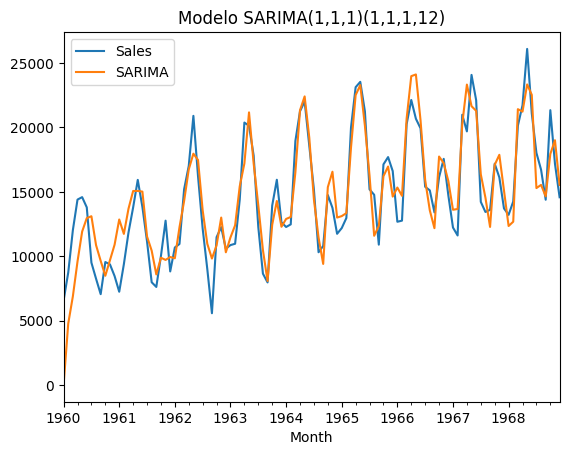

In [5]:
# 5. SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    df['Sales'],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
).fit(disp=False)
df['SARIMA'] = sarima_model.fittedvalues

plt.figure(figsize=(10,4))
df[['Sales','SARIMA']].plot()
plt.title('Modelo SARIMA(1,1,1)(1,1,1,12)')
plt.show()


## 6. Prophet
Descripción: Utilizamos Prophet para modelar tendencias y estacionalidad anual.

c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
22:42:18 - cmdstanpy - INFO - Chain [1] start processing
22:42:18 - cmdstanpy - INFO - Chain [1] done processing


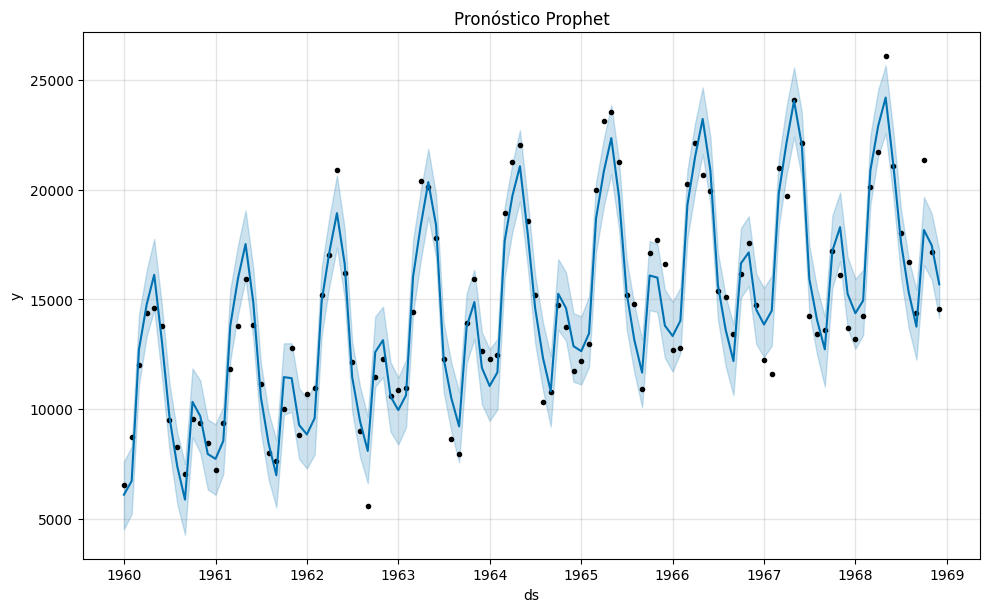

In [8]:
# 6. Prophet
from prophet import Prophet

prophet_df = df['Sales'].reset_index().rename(columns={'Month':'ds','Sales':'y'})
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=0, freq='M')
forecast = prophet_model.predict(future)
df['Prophet'] = forecast.set_index('ds')['yhat']

fig = prophet_model.plot(forecast)
plt.title('Pronóstico Prophet')
plt.show()


## 7. Comparación y Evaluación
Descripción: Calculamos RMSE y MAE de cada modelo y los comparamos.

In [ ]:
# 7. Comparación y Evaluación
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

modelos = ['SES', 'Holt', 'HW', 'SARIMA', 'Prophet']

resultados = []
for m in modelos:
    # MSE
    mse = mean_squared_error(df['Sales'], df[m])
    # RMSE = sqrt(MSE)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(df['Sales'], df[m])
    resultados.append({'Model': m, 'RMSE': rmse, 'MAE': mae})

metrics_df = pd.DataFrame(resultados).set_index('Model')
print("Métricas de Desempeño:")
display(metrics_df)


Métricas de Desempeño:


,RMSE,MAE
Model,,
SES,3300.838578,2609.596544
Holt,3429.987668,2709.944572
HW,1432.713024,1154.359852
SARIMA,2005.790360,1587.980701
Prophet,1248.591714,1025.959595
